# Финальный проект
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

1. **groups.csv** – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
2. **groups_add.csv** – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
3. **active_studs.csv** – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
4. **checks.csv** – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Далее прочтем и выведем входные файлы

In [349]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from tqdm.auto import tqdm
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlencode
import requests

plt.style.use('ggplot')

In [350]:
#Используем API для получения доступа к данным
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
checks_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
active_studs_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

final_url_groups = base_url + urlencode(dict(public_key = groups_url))
final_url_groups_add = base_url + urlencode(dict(public_key = groups_add_url))
final_url_active_studs = base_url + urlencode(dict(public_key = checks_url))
final_url_checks = base_url + urlencode(dict(public_key = active_studs_url))

response_1 = requests.get(final_url_groups)
download_url_1 = response_1.json()['href']

response_2 = requests.get(final_url_groups_add)
download_url_2 = response_2.json()['href']

response_3 = requests.get(final_url_checks)
download_url_3 = response_3.json()['href']

response_4 = requests.get(final_url_active_studs)
download_url_4 = response_4.json()['href']

In [351]:
groups = pd.read_csv(download_url_1, sep = ';')
groups_add = pd.read_csv(download_url_2, sep = ',')
checks = pd.read_csv(download_url_3, sep = ';')
active_studs = pd.read_csv(download_url_4)

In [352]:
data = [groups, groups_add, checks, active_studs]

for i in data:
    display(i.head())

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


### Предварительный анализ датасетов
После того, как мы проверили, что данные корректно считываются - проверим размер и тип данных каждого из датасетов. Также проверим данные на наличие пропусков и дубликатов.

In [353]:
#Проект_2_groups.csv
print(f'Размер датасета: {groups.shape} \n')
print(f'Типы данных: \n{groups.dtypes}')

Размер датасета: (74484, 2) 

Типы данных: 
id      int64
grp    object
dtype: object


In [354]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [355]:
groups.duplicated().sum()

0

In [356]:
#Проект_2_group_add.csv
print(f'Размер датасета: {groups_add.shape} \n')
print(f'Типы данных: \n{groups_add.dtypes}')

Размер датасета: (92, 2) 

Типы данных: 
id      int64
grp    object
dtype: object


In [357]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [358]:
groups_add.duplicated().sum()

0

In [359]:
#Проект_2_checks.csv
print(f'Размер датасета: {checks.shape} \n')
print(f'Типы данных: \n{checks.dtypes}')

Размер датасета: (541, 2) 

Типы данных: 
student_id      int64
rev           float64
dtype: object


In [360]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [361]:
checks.duplicated().sum()

0

In [362]:
#Проект_2_active_studs.csv
print(f'Размер датасета: {active_studs.shape} \n')
print(f'Типы данных: \n{active_studs.dtypes}')

Размер датасета: (8341, 1) 

Типы данных: 
student_id    int64
dtype: object


In [363]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [364]:
active_studs.duplicated().sum()

0

В ходе предварительного анализа выяснили, что пропусков и дублей нет, а все типы данных полностью соответсвуют отображаемым значениям.

Для более удобной дальнейшей работы произведем необходимые преобразования и объединим файлы в один датасет

In [365]:
#Объединяем датасеты groups и groups_add
full_data = pd.concat([groups, groups_add], ignore_index = True)
full_data.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [366]:
'''Объединим получившийся датасет с active_studs, чтобы получить 
информацию по тем пользователям, которые приходили в дни тестирования'''

full_data = full_data.merge(active_studs, left_on = 'id', right_on = 'student_id', how = 'right')
full_data.head()

,id,grp,student_id
0,581585,A,581585
1,5723133,A,5723133
2,3276743,B,3276743
3,4238589,A,4238589
4,4475369,B,4475369


In [367]:
full_data = full_data.drop('student_id', axis = 1)
full_data.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [368]:
#Объединяем датасет с датасетом checks
full_data = full_data.merge(checks, left_on = 'id', right_on = 'student_id', how = 'inner')
full_data = full_data.drop('student_id', axis = 1)

In [369]:
full_data.head()

,id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000


In [370]:
#Посмотрим информацию о получившемся датасете
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      392 non-null    int64  
 1   grp     392 non-null    object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.2+ KB


In [371]:
full_data.isna().sum()

id     0
grp    0
rev    0
dtype: int64

In [372]:
full_data.duplicated().sum()

0

Полученный датасет (full_data) содержит в себе только тех пользователей, которые заходят на платформу. 

Однако стоит также проанализировать тех пользователей, которые не посещали платформу в дни проведения эксперимента, чтобы лучше понимать данные и, возможно, найти в них ошибки

Для этого объединим датасеты с помощью "outer merge". Также для более удобной работы обозначим студентов из датасета active_studs с помощью столбца, который показывает, что пользователь посещал платформу (visit_test).

In [373]:
all_studs = pd.concat([groups, groups_add], ignore_index = True)
all_studs = all_studs.merge(checks, how = 'outer', left_on = 'id', right_on = 'student_id')
all_studs = all_studs.drop('student_id', axis = 1)

In [374]:
act_studs = active_studs
act_studs['visit_test'] = 1

In [375]:
all_studs = all_studs.merge(act_studs, how = 'outer', left_on = 'id', right_on = 'student_id')
all_studs = all_studs.drop('student_id', axis = 1).fillna(0)
all_studs.visit_test = all_studs.visit_test.astype(int)

In [376]:
all_studs.head()

,id,grp,rev,visit_test
0,1489,B,0.0,0
1,1627,A,990.0,1
2,1768,B,0.0,0
3,1783,B,0.0,0
4,1794,A,0.0,0


In [377]:
all_studs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          74576 non-null  int64  
 1   grp         74576 non-null  object 
 2   rev         74576 non-null  float64
 3   visit_test  74576 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [378]:
all_studs.duplicated().sum()

0

Можем заметить, что пустых значений и дублей нет.

Далее проверим тех пользователей, которые не были на платформе в день проведения тестирования, но у них есть проведенная оплата.

In [379]:
all_studs.query('visit_test == 0 and rev != 0').head()

,id,grp,rev,visit_test
39,3185,B,690.0,0
121,25973,B,690.0,0
125,26280,B,690.0,0
223,100645,B,630.0,0
254,102534,B,580.0,0


In [380]:
#Как оказалось такой случай возможен. Проверим количество таких записей в каждой из групп
all_studs.query('visit_test == 0 and rev != 0')\
         .groupby('grp', as_index = False)\
         .agg({'id':'count'})

,grp,id
0,A,29
1,B,120


Можем заметить, что есть 149 записей, в которых есть оплата, но пользователи не заходили на платформу

Возможно, что это платеж за подписку или ошибка в данных. Либо ошибка системы учета входящих пользователей. В любом случае не будем эти записи использовать в дальнейшей работе.

### Изучим распределения величин в каждой из групп

In [381]:
#Посмотрим соотношение двух групп в датасете
print(f'Доля пользователей группы А: {full_data.grp.value_counts(normalize = True).iloc[1].round(5)}')
print(f'Доля пользователей группы В: {full_data.grp.value_counts(normalize = True).iloc[0].round(5)}')

Доля пользователей группы А: 0.19898
Доля пользователей группы В: 0.80102


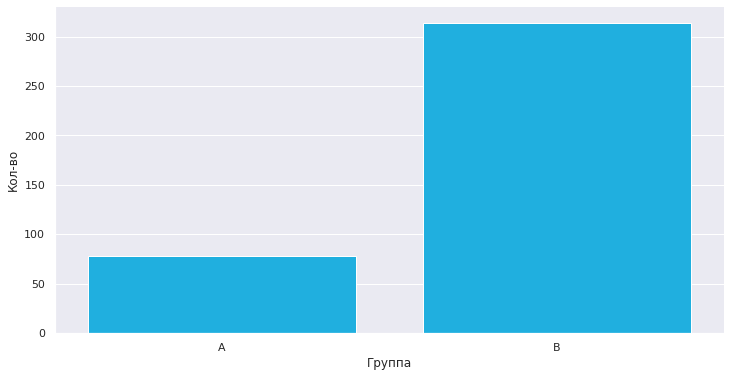

In [382]:
sns.set(rc={'figure.figsize': (12, 6)})
ax = sns.countplot(data = full_data, x = 'grp', color = 'deepskyblue')
ax.set(xlabel = 'Группа', ylabel = 'Кол-во')
sns.despine()

Можем заметить, что пользователей в группе B в 4 раза больше, чем в группе А

Далее рассмотрим распределение суммы покупок в каждой из групп

In [383]:
grp_A = full_data.query('grp == "A"')
grp_B = full_data.query('grp == "B"')

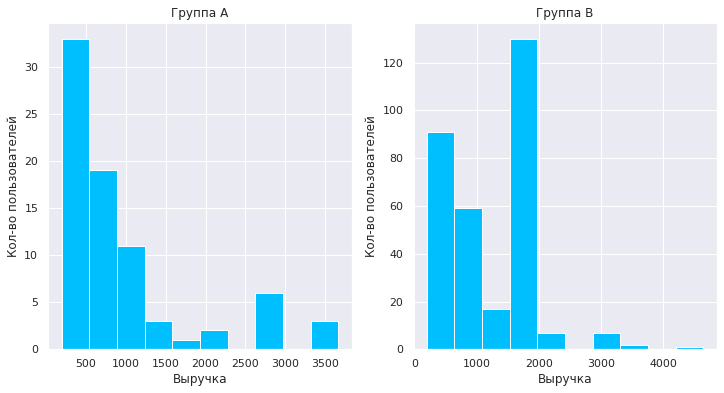

In [384]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(grp_A.rev, color = 'deepskyblue')
axs[0].set_title('Группа A')
axs[0].set(xlabel='Выручка', ylabel='Кол-во пользователей')
axs[1].hist(grp_B.rev, color = 'deepskyblue')
axs[1].set_title('Группа В')
axs[1].set(xlabel='Выручка', ylabel='Кол-во пользователей')
plt.show()

Можем заметить, что распределения в обеих группах отличаются от нормального.

Проверим это утверждение с помощью теста Шапиро-Уилка

In [385]:
# Проверка на нормальность распределения группы А
ss.shapiro(grp_A.rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [386]:
# Проверка на нормальность распределения группы В
ss.shapiro(grp_B.rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

Т.к. для обоих распределений критерий показал pvalue гораздо меньшее, чем 0.05, то мы можем отклонить нулевую гипотезу, которая утверждает, что данная выборка получена из нормального распределения.

Другими словами - оба распределения не являются нормальными.

In [387]:
# Проверка на равенство дисперсий
ss.levene(grp_A.rev, grp_B.rev, center = 'mean')

LeveneResult(statistic=0.35109219559848104, pvalue=0.5538389015879754)

Т.к. критерий показал значение pvalue большее, чем 0.05, то мы не можем отклонить нулевую гипотезу, которая утверждает, что дисперсии в сравниваемых выборках равны.

Другими словами - дисперсии в выборках равны.

*Попробуем исправить ситуацию, прологорифмировав переменную, тем самым сделать распределение более симметричным.*

*И также проверим распределения на нормальность и гомоскедантичность.*

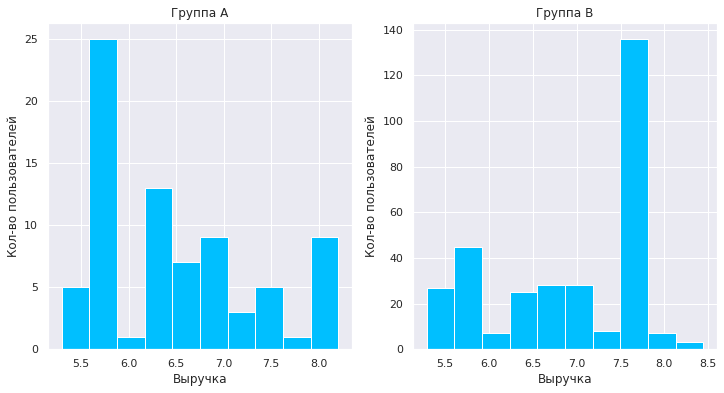

In [388]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(np.log(grp_A.rev), color = 'deepskyblue')
axs[0].set_title('Группа A')
axs[0].set(xlabel='Выручка', ylabel='Кол-во пользователей')
axs[1].hist(np.log(grp_B.rev), color = 'deepskyblue')
axs[1].set_title('Группа В')
axs[1].set(xlabel='Выручка', ylabel='Кол-во пользователей')
plt.show()

In [389]:
# Проверка на нормальность распределения группы А
ss.shapiro(np.log(grp_A.rev))

ShapiroResult(statistic=0.9057686924934387, pvalue=2.680935176613275e-05)

In [390]:
# Проверка на нормальность распределения группы В
ss.shapiro(np.log(grp_B.rev))

ShapiroResult(statistic=0.8419413566589355, pvalue=2.9242029102554055e-17)

Т.к. для обоих распределений критерий показал pvalue гораздо меньшее, чем 0.05, то мы можем отклонить нулевую гипотезу, которая утверждает, что данная выборка получена из нормального распределения.

Другими словами - оба распределения не являются нормальными.

In [391]:
# Проверка на равенство дисперсий
ss.levene(np.log(grp_A.rev), np.log(grp_B.rev), center = 'mean')

LeveneResult(statistic=0.18336047079425533, pvalue=0.6687374476516859)

Т.к. критерий показал значение pvalue большее, чем 0.05, то мы не можем отклонить нулевую гипотезу, которая утверждает, что дисперсии в сравниваемых выборках равны.

Другими словами - дисперсии в выборках равны.

Т.е. преобразование переменной существенно не повлияло на нормальность и равенство дисперсий.

### Тестирование

Перейдем к выбору метрик для проведения тестирования, также сформулируем проверяемые гипотезы и определим, какие статистические тесты необходимо использовать для проверки получившихся гипотез

Все это необходимо для того, чтобы ответить на вопрос: __"Стоит ли запускать новую механику оплаты на всех пользователей?"__

#### Выбор метрик

1. CR в покупку
2. ARPU
3. ARPPU

In [392]:
ARPPU_A = grp_A.rev.sum()/grp_A.id.count()
ARPPU_B = grp_B.rev.sum()/grp_B.id.count()

In [393]:
print(f'ARPPU в группе А: {ARPPU_A.round(2)}')
print(f'ARPPU в группе B: {ARPPU_B.round(2)}')

ARPPU в группе А: 933.59
ARPPU в группе B: 1257.88


Для проверки метрики ARPPU используем Bootstrap

**Bootstrap**
* **H0** - Различий в ARPPU нет
* **H1** - Различия в ARPPU есть

In [394]:
# Реализуем функцию для Bootstrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('deepskyblue')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

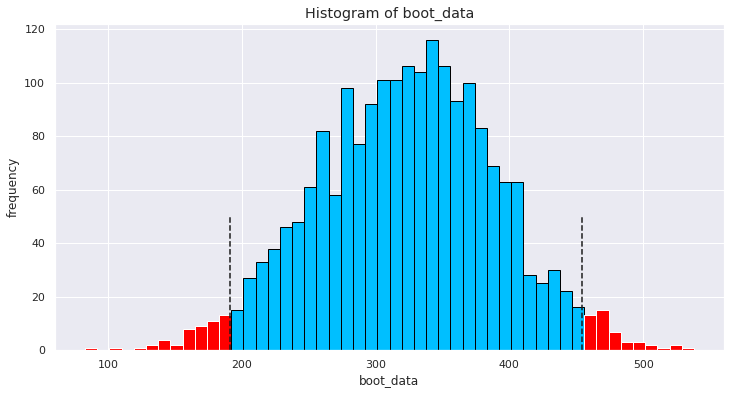

In [395]:
bootstrap_test = get_bootstrap(grp_B.rev, grp_A.rev)

In [396]:
bootstrap_test['p_value']

1.3216158869588248e-06

In [397]:
bootstrap_test['quants']

,0
0.025,191.163068
0.975,454.003675


Т.к. значение p-value сильно меньше граничного уровня значимости (0.05), то мы можем отклонить нулевую гипотезу и сделать вывод, что имеются статистически значимые различия в ARPPU в группах.

Также стоит заметить, что 0 не входит в доверительный интервал.

С помощью статистического метода Хи-квадрат проверим статзначимость изменения конверсии в покупку. Для этого необходимо преобразовать данные, построить таблицу сопряженности и проверить с помощью критерия согласия Пирсона.

**Хи-квадрат**

* **Н0** - новая механика оплаты не повлияла на конверсию
* **Н1** - новая механика оплаты повлияла на конверсию

In [398]:
#CR
cr_df = pd.concat([groups, groups_add], ignore_index = True)
cr_df = cr_df.merge(active_studs, left_on = 'id', right_on = 'student_id', how = 'right')

In [399]:
cr_df = cr_df.drop('student_id', axis = 1)
cr_df.head()

,id,grp,visit_test
0,581585,A,1
1,5723133,A,1
2,3276743,B,1
3,4238589,A,1
4,4475369,B,1


In [400]:
checks['payment'] = 1
checks.head()

,student_id,rev,payment
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [401]:
cr_df = cr_df.merge(checks, left_on = 'id', right_on = 'student_id', how = 'left')

In [402]:
cr_df = cr_df.drop('student_id', axis = 1).fillna(0)

In [403]:
cr_df.payment = cr_df.payment.astype('int')
cr_df.head()

,id,grp,visit_test,rev,payment
0,581585,A,1,0.0,0
1,5723133,A,1,0.0,0
2,3276743,B,1,0.0,0
3,4238589,A,1,0.0,0
4,4475369,B,1,0.0,0


Чтобы проверить различия в конверсиях, используем хи2

Для этого построим таблицу сопряженности

In [404]:
A_pay = cr_df.query('grp == "A" and payment == 1').id.count()
A_no_pay = cr_df.query('grp == "A" and payment == 0').id.count()
B_pay = cr_df.query('grp == "B" and payment == 1').id.count()
B_no_pay = cr_df.query('grp == "B" and payment == 0').id.count()

In [405]:
# Построим таблицу сопряженности
cr_matrix = pd.DataFrame({'payment':[A_pay, B_pay], 'no_payment':[A_no_pay, B_no_pay]})
cr_matrix.index = ['A', 'B']
cr_matrix

,payment,no_payment
A,78,1460
B,314,6489


In [406]:
cr_res = ss.chi2_contingency(cr_matrix)
print(f'statistic: {cr_res[0]}')
print(f'p-value: {cr_res[1]}')

statistic: 0.48480826522557896
p-value: 0.48625240457231045


Т.к. p-value > 0.05, то принимаем нулевую гипотезу. То есть, что мы не имеем различия в конверсиях двух выборок

Далее проверим метрику ARPU 

**Bootstrap**
* **H0** - Различий в ARPU нет
* **H1** - Различия в ARPU есть

In [407]:
#ARPU
ARPU_df = cr_df
ARPU_df.head()

,id,grp,visit_test,rev,payment
0,581585,A,1,0.0,0
1,5723133,A,1,0.0,0
2,3276743,B,1,0.0,0
3,4238589,A,1,0.0,0
4,4475369,B,1,0.0,0


In [408]:
ARPU_A = ARPU_df.query('grp == "A"').rev.sum()/ARPU_df.query('grp == "A"').id.nunique()
ARPU_B = ARPU_df.query('grp == "B"').rev.sum()/ARPU_df.query('grp == "B"').id.nunique()

In [409]:
print(f'ARPU в группе А: {ARPU_A.round(2)}')
print(f'ARPU в группе B: {ARPU_B.round(2)}')

ARPU в группе А: 47.35
ARPU в группе B: 58.06


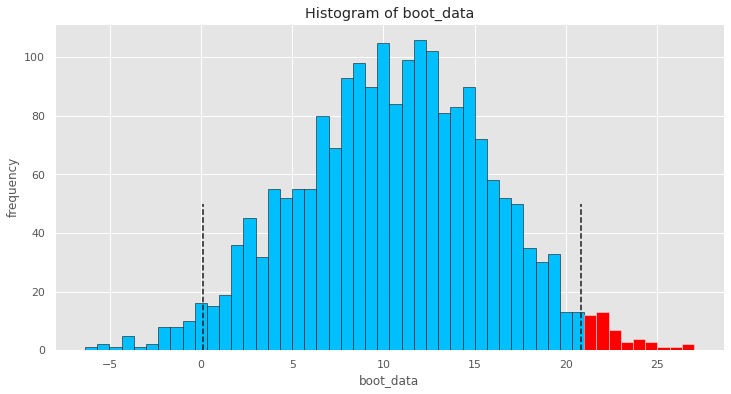

In [410]:
bootstrap_test_ARPU = get_bootstrap(ARPU_df.query('grp == "B"').rev, ARPU_df.query('grp == "A"').rev)

In [411]:
bootstrap_test_ARPU['p_value']

0.04475894150933411

In [412]:
bootstrap_test_ARPU['quants']

,0
0.025,0.108306
0.975,20.820771


Т.к. значение p-value сильно меньше граничного уровня значимости (0.05), то мы можем отклонить нулевую гипотезу и сделать вывод, что имеются статистически значимые различия в ARPU в группах.

### ВЫВОДЫ:

* **Стоит ли запускать новую механику оплаты на всех пользователей?**

Для сравнения и тестирования были проверены следующие метрики: CR в покупку, ARPPU и ARPU. 

При проверке конверсии с помощью метода Хи-квадрат результат не дал статзначимых различий, несмотря на то, что показатели конверсии в группе В меньше, чем в группе А. 

При сравнении в группах метрик ARPPU и ARPU был получен результат, показывающий статзначимые различия в контрольной и тестовой группах. В тестовой группе показатели оказались выше, чем в контрольной.

Отвечая на поставленный вопрос: Новую механику оплаты можно запускать. Ожидается, что благодаря ей можно уввеличить средний доход.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

#### 2.1.2 Задача

Дана таблица default.peas. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [413]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'default',
              'user':'student', 
              'password':'dpo_python_2020'}

In [414]:
# Посмотрим содержимое таблицы peas
query = """
SELECT
    st_id,
    toStartOfDay(timest) AS timest,
    correct,
    subject
FROM default.peas
LIMIT 10
"""

peas_df = ph.read_clickhouse(query, connection=connection)
peas_df

,st_id,timest,correct,subject
0,100379,2021-10-30,1,Theory of probability
1,100379,2021-10-30,0,Vizualization
2,100379,2021-10-30,1,Theory of probability
3,100379,2021-10-30,1,Vizualization
4,100379,2021-10-30,1,Theory of probability
5,100379,2021-10-30,1,Theory of probability
6,100379,2021-10-30,1,Vizualization
7,100379,2021-10-30,0,Theory of probability
8,100379,2021-10-30,1,Vizualization
9,100379,2021-10-30,1,Theory of probability


**Заметим, что в БД содержатся данные только за два дня**

In [415]:
# Выведем минимальное и максимальное значение даты
query = """
SELECT
    MIN(toStartOfDay(timest)) AS min_timest,
    MAX(toStartOfDay(timest)) AS max_timest
FROM default.peas
"""

check_df = ph.read_clickhouse(query, connection=connection)
check_df

,min_timest,max_timest
0,2021-10-30,2021-10-31


In [416]:
# Узнаем количество очень усердных учеников
query = """
SELECT
    COUNT(st_id) as diligent_studs
FROM (
        SELECT 
            st_id,
            SUM(correct) as total_peas
        FROM default.peas
        GROUP BY st_id
        HAVING total_peas >=20
     )
"""

df_1 = ph.read_clickhouse(query, connection=connection)
print(f'Количество очень усердных учеников: {df_1.diligent_studs[0]}')

Количество очень усердных учеников: 136


### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: default.peas, default.studs и default.final_project_check. 

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [417]:
# Посмотрим содержимое таблицы studs
query = """
    SELECT *
    FROM default.studs
    LIMIT 10
"""

studs_df = ph.read_clickhouse(query, connection = connection)
studs_df

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot
5,106010,pilot
6,106028,pilot
7,106464,pilot
8,106816,control
9,107250,control


In [418]:
# Посмотрим содержимое таблицы final_project_check
query = """
    SELECT
        st_id,
        toStartOfDay(sale_time) AS sale_time,
        money,
        subject
    FROM default.final_project_check
    LIMIT 10
"""

studs_df = ph.read_clickhouse(query, connection = connection)
studs_df

,st_id,sale_time,money,subject
0,101432,2021-10-31,85000,Math
1,101432,2021-10-31,65000,Vizualization
2,104885,2021-10-30,65000,Vizualization
3,104885,2021-10-30,75000,Statistics
4,106464,2021-10-31,85000,Math
5,114606,2021-10-31,75000,Statistics
6,147316,2021-10-31,65000,Vizualization
7,149640,2021-10-30,65000,Vizualization
8,230858,2021-10-31,85000,Math
9,269738,2021-10-30,70000,Theory of probability


Для решения данной задачи составим несколько подзапросов, чтобы упростить дальнейший расчет интересующих метрик

In [419]:
query = """
WITH studs_by_grp AS
    (
    SELECT 
        test_grp,
        uniqExact(st_id) AS studs_count
    FROM default.studs
    GROUP BY test_grp
    ), -- кол-во учеников в каждой из групп
    
     total_money AS
    (
    SELECT
        a.test_grp AS test_grp,
        SUM(b.money) AS tot_money
    FROM default.studs AS a
    INNER JOIN default.final_project_check AS b
    USING st_id
    GROUP BY test_grp
    ), -- общий доход с покупок учеников
    
    active_studs AS
    (
    SELECT
        test_grp,
        uniqExact(st_id) AS act_studs
    FROM 
        (
        SELECT
            a.st_id AS st_id,
            b.test_grp AS test_grp
        FROM default.peas AS a
        INNER JOIN default.studs AS b
        USING st_id
        GROUP BY test_grp, st_id
        HAVING SUM(correct) > 10
        )
    GROUP BY test_grp
    ), -- кол-во активных учеников
    
    math_active_studs AS
    (
    SELECT
        test_grp,
        uniqExact(st_id) AS math_act_studs
    FROM 
        (
        SELECT
            a.st_id AS st_id,
            b.test_grp AS test_grp
        FROM default.peas AS a
        INNER JOIN default.studs AS b
        USING st_id
        WHERE subject = 'Math'
        GROUP BY test_grp, st_id
        HAVING SUM(correct) >= 2
        )
    GROUP BY test_grp
    ), -- кол-во активных учеников по математике
     
    paying_studs AS
    (
    SELECT
        a.test_grp AS test_grp,
        uniqExact(st_id) AS pay_studs
    FROM default.studs AS a
    INNER JOIN default.final_project_check AS b
    USING st_id
    GROUP BY test_grp
    ), -- кол-во учеников, совершивших покупку
    
    active_paying_studs AS
    (
    SELECT
        test_grp,
        uniqExact(st_id) AS act_pay_studs
    FROM 
        (
        SELECT 
            a.test_grp AS test_grp,
            a.st_id AS st_id
        FROM (
            SELECT
                a.st_id AS st_id,
                b.test_grp AS test_grp
            FROM default.peas AS a
            LEFT JOIN default.studs AS b
            USING st_id
            GROUP BY test_grp, st_id
            HAVING SUM(a.correct) > 10
            ) AS a
        INNER JOIN default.final_project_check AS b
        USING (st_id)
        )
    GROUP BY test_grp
    ), -- кол-во активных студентов, совершивших покупку
    
    math_active_paying_studs AS
    (
    SELECT
        test_grp,
        uniqExact(st_id) AS math_act_pay_studs
    FROM 
        (
        SELECT
            a.test_grp AS test_grp,
            a.st_id AS st_id
        FROM
            (
            SELECT
                a.st_id AS st_id,
                b.test_grp AS test_grp
            FROM default.peas AS a
            INNER JOIN default.studs AS b
            USING st_id
            WHERE subject = 'Math'
            GROUP BY test_grp, st_id
            HAVING SUM(correct) >= 2
            ) AS a
        INNER JOIN default.final_project_check AS b
        USING st_id
        WHERE b.subject = 'Math'
        GROUP BY test_grp, st_id
        )
    GROUP BY test_grp
    ) -- кол-во активных студентов по математике, совершивших покупку
    
SELECT
    a.test_grp AS test_grp,
    b.tot_money/a.studs_count AS ARPU,
    b.tot_money/c.act_studs AS ARPAU,
    d.act_pay_studs/a.studs_count * 100 AS CR_to_buy, -- конверсия в покупку
    d.act_pay_studs/c.act_studs * 100 AS CR_act_stud_to_buy, -- конверсия активного пользователя в покупку 
    e.math_act_pay_studs/ f.math_act_studs * 100 AS CR_math -- пользователя из активности по математике в покупку курса по математике
FROM studs_by_grp AS a
    LEFT JOIN total_money AS b
        ON a.test_grp = b.test_grp
    LEFT JOIN active_studs AS c
        ON a.test_grp = c.test_grp
    LEFT JOIN active_paying_studs AS d
        ON a.test_grp = d.test_grp
    LEFT JOIN math_active_paying_studs AS e
        ON a.test_grp = e.test_grp
    LEFT JOIN math_active_studs AS f
        ON a.test_grp = f.test_grp
"""

df_2 = ph.read_clickhouse(query, connection=connection)
df_2

,test_grp,ARPU,ARPAU,CR_to_buy,CR_act_stud_to_buy,CR_math
0,control,4540.983607,10905.511811,4.590164,11.023622,6.122449
1,pilot,11508.474576,35364.583333,8.474576,26.041667,9.523810


## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [420]:
# Реализация функции
def update_data(group_df, checks_df, active_studs_df, data_add_file):
    data_add = pd.read_csv(data_add_file, sep = ',', header = 0, names = ['id', 'grp'])
    
    df_united = pd.concat([group_df, data_add], ignore_index = True)
    df_united = df_united.merge(active_studs_df, left_on = 'id', right_on = 'student_id', how = 'right')
    df_united = df_united.drop('student_id', axis = 1)
    checks_df['payment'] = 1
    df_united = df_united.merge(checks_df, left_on = 'id', right_on = 'student_id', how = 'left')
    df_united = df_united.drop('student_id', axis = 1).fillna(0)
    df_united.payment = df_united.payment.astype('int')
    
    #CR
    a_pay = df_united.query('grp == "A" and payment == 1').id.count()
    a_total = df_united.query('grp == "A"').id.count()
    b_pay = df_united.query('grp == "B" and payment == 1').id.count()
    b_total = df_united.query('grp == "B"').id.count()
    
    cr_a = round(a_pay / a_total * 100, 2)
    cr_b = round(b_pay / b_total * 100, 2)
    
    #ARPU
    arpu_a = (df_united.query('grp == "A"').rev.sum() / df_united.query('grp == "A"').id.nunique()).round(2)
    arpu_b = (df_united.query('grp == "B"').rev.sum() / df_united.query('grp == "B"').id.nunique()).round(2)
    
    #ARPPU
    arppu_a = (df_united.query('grp == "A"').rev.sum() / df_united.query('grp == "A" and payment == 1').id.nunique()).round(2)
    arppu_b = (df_united.query('grp == "B"').rev.sum() / df_united.query('grp == "B" and payment == 1').id.nunique()).round(2)
    
    print(f'Конверсия в покупку для контрольной группы (А): {cr_a} %')
    print(f'Конверсия в покупку для тестовой группы (В): {cr_b} % \n')
    
    print(f'ARPU для контрольной группы (А): {arpu_a.round(2)}')
    print(f'ARPU для тестовой группы (В): {arpu_b.round(2)} \n')
    
    print(f'ARPPU для контрольной группы (А): {arppu_a.round(2)}')
    print(f'ARPPU для тестовой группы (В): {arppu_b.round(2)} \n')
    
    visualisation = pd.DataFrame({'Groups': ["A", "B"],
                                  'CR': [cr_a, cr_b],
                                  'ARPU': [arpu_a, arpu_b],
                                  'ARPPU': [arppu_a, arppu_b]})
    
    fig, axs = plt.subplots(1, 3, figsize = (17, 7))
    
    ax1 = sns.barplot(ax = axs[0], data = visualisation, x = 'Groups', y = 'CR', color = 'deepskyblue')
    ax1.set(xlabel = 'Группа', ylabel = 'Конверсия в покупку')
    ax2 = sns.barplot(ax = axs[1], data = visualisation, x = 'Groups', y = 'ARPU', color = 'deepskyblue')
    ax2.set(xlabel = 'Группа', ylabel = 'ARPU')
    ax3 = sns.barplot(ax = axs[2], data = visualisation, x = 'Groups', y = 'ARPPU', color = 'deepskyblue')
    ax3.set(xlabel = 'Группа', ylabel = 'ARPPU')
    sns.despine()
    
    return visualisation

Конверсия в покупку для контрольной группы (А): 5.07 %
Конверсия в покупку для тестовой группы (В): 4.62 % 

ARPU для контрольной группы (А): 47.35
ARPU для тестовой группы (В): 58.06 

ARPPU для контрольной группы (А): 933.59
ARPPU для тестовой группы (В): 1257.88 



,Groups,CR,ARPU,ARPPU
0,A,5.07,47.35,933.59
1,B,4.62,58.06,1257.88


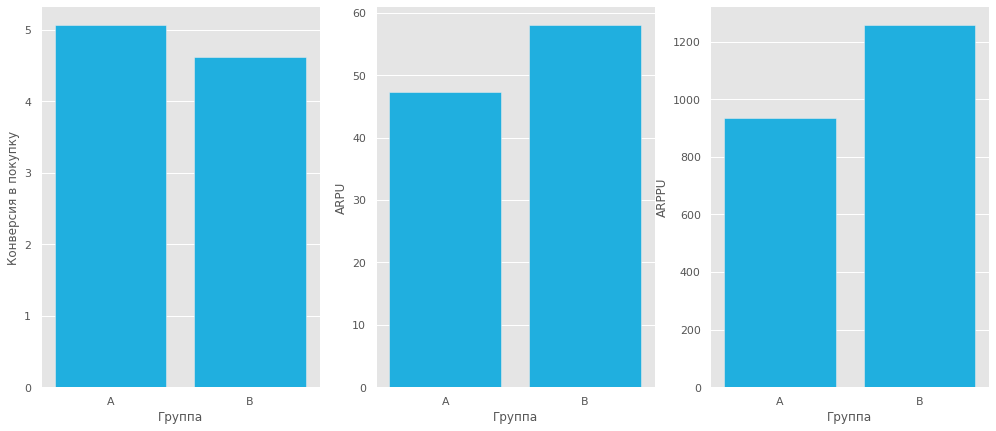

In [421]:
# Применим реализованную функцию
update_data(groups, checks, active_studs, download_url_2)